# **Fresh Check Model**

# Download and Prepare the Dataset




In [1]:
# install library
! pip install -q kaggle

# import library
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wifalinola","key":"4e9a61959213153b03d226514bc60021"}'}

In [3]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

100% 1.41G/1.41G [01:17<00:00, 6.75MB/s]
100% 1.41G/1.41G [01:17<00:00, 19.5MB/s]


In [4]:
! unzip fresh-and-stale-images-of-fruits-and-vegetables.zip -d '/content/fresh-and-stale-images-of-fruits-and-vegetables'

Streaming output truncated to the last 5000 lines.
  inflating: /content/fresh-and-stale-images-of-fruits-and-vegetables/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.09 PM.png  
  inflating: /content/fresh-and-stale-images-of-fruits-and-vegetables/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.15 PM.png  
  inflating: /content/fresh-and-stale-images-of-fruits-and-vegetables/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.24 PM.png  
  inflating: /content/fresh-and-stale-images-of-fruits-and-vegetables/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.32 PM.png  
  inflating: /content/fresh-and-stale-images-of-fruits-and-vegetables/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.38 PM.png  
  inflating: /content/fresh-and-stale-images-of-fruits-and-vegetables/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.21 PM.png  
  inflating: /content/fresh-and-stale-images-of-fruits-and-vegetables/stale_banana/rotated_by_15_Screen Shot 

# Prepare the ImageDataGenerator

In [5]:
BASE_DIR = '/content/fresh-and-stale-images-of-fruits-and-vegetables/'

trainings_datagen = ImageDataGenerator(
    rescale=1 / 255,
    fill_mode='nearest',
    validation_split=0.2 # Trainingnya 80% Validasinya 20% (validasi = test),
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = trainings_datagen.flow_from_directory(
    BASE_DIR,
    class_mode='categorical',
    seed=42,
    target_size=(224, 224),
    shuffle=True,
    subset='training')
validation_generator = val_datagen.flow_from_directory(
    BASE_DIR,
    seed=42,
    class_mode='categorical',
    target_size=(224, 224),
    subset='validation')

Found 11749 images belonging to 12 classes.
Found 2933 images belonging to 12 classes.


## Transfer learning - Create the pre-trained model



In [6]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-16 10:13:07--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  20.0MB/s    in 5.2s    

2023-06-16 10:13:13 (16.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
# grader-required-cell

# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

## Creating callbacks for later



In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') >= 0.999:  # Modify the condition as per your requirement
            print("\nReached desired training accuracy. Stopping training...")
            self.model.stop_training = True

## Pipelining the pre-trained model with your own

Now that the pre-trained model is ready, you need to "glue" it to your own model to solve the task at hand.

For this you will need the last output of the pre-trained model, since this will be the input for your own.

In [9]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


In [21]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
# Add a dropout
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (12, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

## Train the Model

In [22]:
# Create an instance of the custom callback
callbacks = myCallback()

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_steps=50,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/100
100/100 - 32s - loss: 23.9358 - acc: 0.7353 - val_loss: 7.4646 - val_acc: 0.8487 - 32s/epoch - 323ms/step
Epoch 2/100
100/100 - 24s - loss: 2.8564 - acc: 0.8746 - val_loss: 6.2583 - val_acc: 0.7481 - 24s/epoch - 244ms/step
Epoch 3/100
100/100 - 26s - loss: 2.0233 - acc: 0.9003 - val_loss: 5.7109 - val_acc: 0.8081 - 26s/epoch - 264ms/step
Epoch 4/100
100/100 - 27s - loss: 1.3959 - acc: 0.9184 - val_loss: 4.0651 - val_acc: 0.8687 - 27s/epoch - 267ms/step
Epoch 5/100
100/100 - 25s - loss: 1.1479 - acc: 0.9206 - val_loss: 3.1180 - val_acc: 0.8756 - 25s/epoch - 246ms/step
Epoch 6/100
100/100 - 26s - loss: 1.2485 - acc: 0.9072 - val_loss: 3.9426 - val_acc: 0.8306 - 26s/epoch - 258ms/step
Epoch 7/100
100/100 - 36s - loss: 1.0906 - acc: 0.9332 - val_loss: 3.2221 - val_acc: 0.8963 - 36s/epoch - 363ms/step
Epoch 8/100
100/100 - 26s - loss: 0.9878 - acc: 0.9303 - val_loss: 3.1571 - val_acc: 0.8844 - 26s/epoch - 260ms/step
Epoch 9/100
100/100 - 26s - loss: 0.9317 - acc: 0.9367 - val_lo

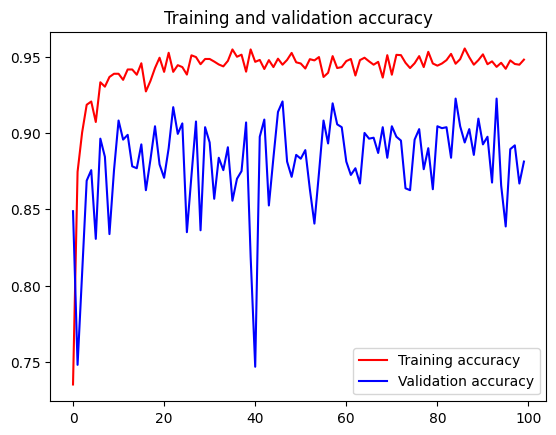

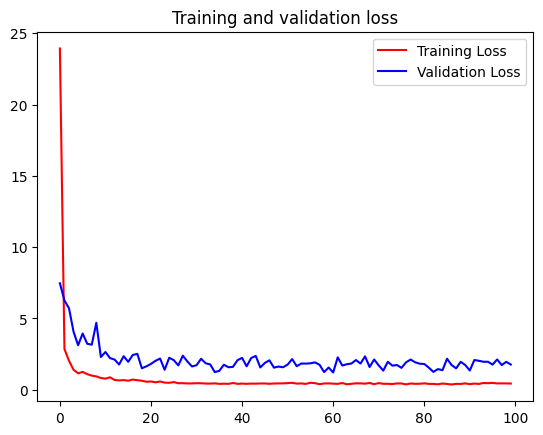

In [23]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
saved_model_path = "./my_model.h5"

# YOUR CODE HERE
model.save(saved_model_path)

In [24]:
from PIL import Image
import io
with open('fresh_apple_2.png', 'rb') as file:
    image_bytes = file.read()
    pillow_img = Image.open(io.BytesIO(image_bytes)).convert('L')

import numpy as np
pillow_image = pillow_img.convert('RGB')  # Convert image to RGB
data = np.asarray(pillow_image)
data = data / 255.0
data = tf.image.resize(data, [224, 224])
data = np.expand_dims(data, axis=0)  # Add a batch dimension

predictions = model.predict(data)
pred0 = predictions[0]
label0 = np.argmax(pred0)
class_labels = train_generator.class_indices
labels = list(class_labels.keys())
predicted_label = labels[label0]
print(label0)
print(predicted_label)

1/1 [==============================] - 1s 1s/step
0
fresh_apple
